# Prosty algorytm ewolucyjny

Przykład **ilustracyjny** - pokazuje jak bardzo proste obliczenia mogą prowadzić do uzyskania rozwiązań nietrywialnych problemów. 
Jeśli zainteresowała Cię tematyka Algorytmów Ewolucyjnych / Genetycznych - zachęcam do zgłębienia wiedzy na ten temat.

Poniżej prezentujemy algorytm genetyczny do rozwiązywania równań z jedną niewiadomą, postaci: $f(x) = 0$ dla *dowolnego* $f\colon[0,1]\to\mathbb{R}$. Nie zakładamy *niczego* specjalnego o $f$. Zwróćmy uwagę, że równanie postaci $f(x) = 0$ to najbardziej ogólna postać **dowolnego** równania z jedną niewiadomą! Zero po prawej stronie równania, możemy zapewnić w dowolnym równaniu przenosząc składniki z prawej na lewą stronę stosując metody znane ze szkoły podstawowej. Zatem rozwiązywany przez nas problem, to w istocie poszukiwanie algorytmu, który umie rozwiązać *dowolne* równanie. 

Jeśli istnieje conajmniej jedno rozwiązanie tego równania, algorytm powinien zwrócić jego (bardzo dobre) przybliżenie. Jeśli istnieje więcej niż jedno rozwiązanie, algorytm powinien znaleźć przybliżenie jednego z rozwiązań. Jeśli rozwiązanie nie istnieje, algorytm może zwrócić cokolwiek.

Oczywiście pamiętajmy o tym, że jest to przykład bardzo prosty i z pewnością da się dobrać równania, których ten algorytm nie umie rozwiązać. Ponadto, formalnie rzecz biorąc nie otrzymujemy tu rozwiązania, a jedynie przybliżenie rozwiązania. Z drugiej jednak strony, algorytm radzi sobie bardzo dobrze z dużą klasą równań - nawet z takimi, których nie da się rozwiązać analitycznie (np. na kartce papieru, stosując jakieś przekształcenia i wyliczenia). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Poniższa funkcja zapewnia nam, że $x$ nigdy nie trafi poza przedział $[0,1]$.

In [2]:
def interval(x):
    return np.clip(x, 0.0, 1.0)

Sprawdźmy czy zdefiniowana przez nas funkcja działa:

In [3]:
print(interval(-0.1))
print(interval(0.1))
print(interval(1.1))

0.0
0.1
1.0


Dwie podstawowe operacje algorytmu ewolucyjnego to **krzyżowanie** (_ang. cross-over_) i **mutacja** (_ang. mutation_). Poniższe dwie funkcje implementują proste operacje krzyżowania i mutacji, odpowiednie dla $x\in[0,1]$. W przypadku gdy poszukujemy rozwiązania w innym zbiorze, funkcje te mogą wymagać poprawy. Warto zauważyć, że są to bardzo proste warianty tych funkcji. W bardziej złożonych problemach stosuje się nieco inne warianty - jednak idea pozostaje dokładnie taka sama. Krzyżowanie ma "wyprodukować" wartość dziedziczącą nieco cech jednego i drugiego rodzica, natomiast mutacja ma delikatnie zaburzyć daną wartość.

In [4]:
def cross(x, y, prop = 0.5):
    return 0.5 * x + (1 - prop) * y

def mutate(x, mut_strength = 0.001):
    return interval(x + np.random.normal(loc=0.0, scale=mut_strength))

Zobaczmy jak w praktyce działają te operacje:

In [5]:
print("Crossover 0.1 i 0.9 to: ", cross(0.1, 0.9))

print("Kilka mutacji osobnika x=0.5: ")
for _ in range(10):
    print(mutate(0.5))

Crossover 0.1 i 0.9 to:  0.5
Kilka mutacji osobnika x=0.5: 
0.4991718416063353
0.49943061207330447
0.4992834899683008
0.5013743195916867
0.49987414206369757
0.4994231011053133
0.4999944799436723
0.49951780784751254
0.4994739385856945
0.4997375702441421


Teraz definiujemy funkcje odpowiedzialne za wyliczanie wartości tzw. **funkcji dopasowania** (_ang. fitness function_). Funkcja dopasowania mówi o tym na ile dany osobnik sprawdza się jako rozwiązanie. W naszym przypadku, będzie to po prostu wartość bezwzględna z funkcji $f$ stanowiącej lewą stronę naszego równania $f(x) = 0$.

Funkcja *fitness_on_population* stosuje funkcję $f$ na całej zadanej populacji.

Funkcja *normalized_fitness* transformuje otrzymane wartości funkcji dopasowania, tak aby: (a) sumowały się do 1, (b) wartość najwyższa odpowiadała najlepszemu rozwiązaniu. Dzięki temu wartości te idealnie nadają się do użycia w funkcji *np.random.choice* jako **prawdopodobieństwa** wyboru. 


In [6]:
def fitness_on_population(population, func):
    return np.abs(np.vectorize(func)(population))

def normalized_fitness(population, func):
    res = fitness_on_population(population, func)
    res = 1.0 - (res / np.max(res))
    return res / np.sum(res)
    

Zobaczmy jak użyć zdefiniowaną przez nas funkcje.

In [7]:
test_func = lambda x: x**2-0.5
test_population = np.arange(11) * 0.1
print(test_population)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [8]:
fitness_on_population(test_population, test_func)

array([0.5 , 0.49, 0.46, 0.41, 0.34, 0.25, 0.14, 0.01, 0.14, 0.31, 0.5 ])

In [9]:
normalized_fitness(test_population, test_func)

array([0.        , 0.00512821, 0.02051282, 0.04615385, 0.08205128,
       0.12820513, 0.18461538, 0.25128205, 0.18461538, 0.0974359 ,
       0.        ])

A tak wyniki tych funkcji wyglądają na wykresie. Zwróć uwagę na kształt wykresu. 

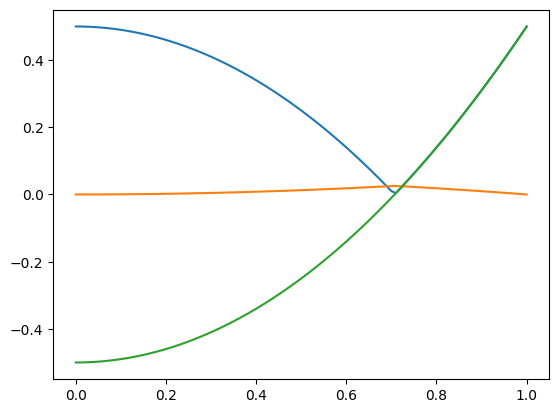

In [10]:
test_population = np.arange(101) * 0.01

X = test_population

Y = fitness_on_population(test_population, test_func)
plt.plot(X, Y)

Y_norm = normalized_fitness(test_population, test_func)
plt.plot(X, Y_norm)

Y_func = list(map(test_func, X))
plt.plot(X, Y_func)

plt.show()

Na bazie funkcji dopasowania (fitness), możemy zdefiniować ostatni z operatorów genetycznych, czyli operator **selekcji** / wyboru. Stosujemy wybór losowy, z prawdopodobieństwem wyboru proporocjonalnym do wartości funkcji dopasowania. Podobnie jak w przypadku operatorów mutacji i krzyżowania, istnieje wiele wariantów tego operatora. Warto zwrócić uwagę, że wszystkie 3 operatory algorytmu genetycznego **nie** zależą od definicji funkcji dopasowania. Jedynie sama funkcja dopasowania ma związek z rozwiązywanym przez nas problemem i może być traktowana jako wejście algorytmu. Operatory genetyczne są natomiast czymś uniwersalnym co _powinno_ działać w wielu przypadkach. Oczywiście jednak, zależnie od poziomu złożoności naszego problemu, może istnieć konieczność modyfikacji tych ogólnych operatorów, tak aby otrzymać lepsze wyniki.

In [11]:
def choice(population, normalized_fitness_values):
    return np.random.choice(population, 1, p=normalized_fitness_values)[0]

Funkcja wyboru nie jest deterministyczna - za każdym uruchomieniem może dać nam inny wyniki. Ilustruje to poniższy prosty eksperyment w którym 100 razy wybieramy losowo element, a następnie na histogramie pokazujemy jak często poszczególne elementy zostały wybrane. 

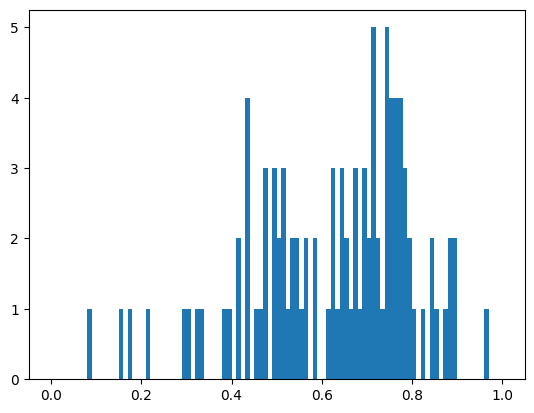

[0.08 0.15 0.17 0.21 0.29 0.3  0.32 0.33 0.38 0.39 0.41 0.41 0.43 0.43
 0.43 0.43 0.45 0.46 0.47 0.47 0.47 0.49 0.49 0.49 0.5  0.5  0.51 0.51
 0.51 0.52 0.53 0.53 0.54 0.54 0.55 0.56 0.56 0.58 0.58 0.61 0.62 0.62
 0.62 0.63 0.64 0.64 0.64 0.65 0.65 0.66 0.67 0.67 0.67 0.68 0.69 0.69
 0.69 0.7  0.7  0.71 0.71 0.71 0.71 0.71 0.72 0.72 0.73 0.74 0.74 0.74
 0.74 0.74 0.75 0.75 0.75 0.75 0.76 0.76 0.76 0.76 0.77 0.77 0.77 0.77
 0.78 0.78 0.78 0.79 0.79 0.8  0.82 0.84 0.84 0.85 0.87 0.88 0.88 0.89
 0.89 0.96]


In [12]:
X = np.arange(101) * 0.01                            # dummy population
Y = normalized_fitness(X, lambda x: x**2-0.5)        # fitness values

choices = np.sort([choice(X,Y) for _ in range(100)])

plt.hist(choices, bins=X)
plt.show()
print(choices)

## Implementacja głównego algorytmu
Mając za sobą definicję funkcji dopasowania (_fitness_), operatorów mutacji (_mutate_), krzyżowania (_cross-over_) oraz wyboru (_selection_), może w końcu podać implementację samego algorytmu genetycznego. Algorytm ten startuje od losowej populacji osobników - kandydatów na rozwiązania, a następnie przez zadaną liczbę iteracji produkuje kolejne populacje, bazując na populacji porzedniej i zdefiniowanych operatorach. Ten sam proces powtarzany jest w kółko i za każdym razem jest taki sam - zmienia się jednak sama populacja, z początkowego chaosu wyłania się porządek - coraz silniejsze osobniki / kandydaci na rozwiązanie zaczynają dominować a ich cechy są propagowane dalej. 

In [13]:
def ga_solve(func, population_size = 20, iterations = 1000):
    population = np.random.random(population_size)

    for _ in range(iterations):
        fitness_results = normalized_fitness(population, func)
        population = np.array([mutate(
                                          cross(
                                                choice(population, fitness_results), 
                                                choice(population, fitness_results)
                                                )
                                        ) for _ in range(population_size)])
    
    return population[int(np.argmin(fitness_on_population(population, func)))]    

# Przykłady

### Przykład 1. Równanie kwadratowe.

Równanie $x^2 - \frac{1}{2} = 0$ dla $x\in[0,1]$.

In [14]:
f = lambda x: x**2 - 0.5

best_candidate = ga_solve(f, population_size = 50, iterations = 50)
print("Best candidate: ", best_candidate)
print("Error (value of |f(best candidate)|): ", np.abs(f(best_candidate)))

exact = 1/np.sqrt(2)
print("Exact solution: ", exact)
print("Difference between best and exact: ", np.abs(best_candidate - exact))


Best candidate:  0.7005121162668959
Error (value of |f(best candidate)|):  0.009282774963274898
Exact solution:  0.7071067811865475
Difference between best and exact:  0.0065946649196515494


### Przykład 2. Równanie trygonometryczne.

Równanie $\sin (\pi\, x) - \frac{1}{2} = 0$ dla $x\in[0,1]$.

In [15]:
f = lambda x: np.sin(np.pi * x) - 0.5

best_candidate = ga_solve(f, population_size = 50, iterations = 50)
print("Best candidate: ", best_candidate)
print("Error (value of |f(best candidate)|): ", np.abs(f(best_candidate)))

exact = np.array([1/6, 5/6])
print("Exact solutions: ", exact)
print("Difference between best and exact: ", np.abs(best_candidate - exact))


Best candidate:  0.16665581485891112
Error (value of |f(best candidate)|):  2.9524793571433783e-05
Exact solutions:  [0.16666667 0.83333333]
Difference between best and exact:  [1.08518078e-05 6.66677518e-01]


### Przykład 3. Równanie logarytmiczne.

Równanie $\log_2(10\,x) - \log_{10}(2\, x) = 0$ dla $x\in[0,1]$.

In [16]:
f = lambda x: np.log2(10 * x) - np.log10(2 * x)

best_candidate = ga_solve(f, population_size = 50, iterations = 1000)
print("Best candidate: ", best_candidate)
print("Error (value of |f(best candidate)|): ", np.abs(f(best_candidate)))

exact = 1/20
print("Exact solutions: ", exact)
print("Difference between best and exact: ", np.abs(best_candidate - exact))


Best candidate:  0.04995875919593167
Error (value of |f(best candidate)|):  0.0008320882045700362
Exact solutions:  0.05
Difference between best and exact:  4.1240804068330694e-05


### Przykład 4. Równanie kwadratowo-trygonometryczno-logarytmiczne.

Równanie $-\log_2(x) - x^2 + \sin(2\pi\,x) = 0$ dla $x\in[0,1]$.

W tym przypadku zaczniemy od narysowania wykresu funkcji $|f|$, bo nie każdy jest w stanie sobie ją wyobrazić... 

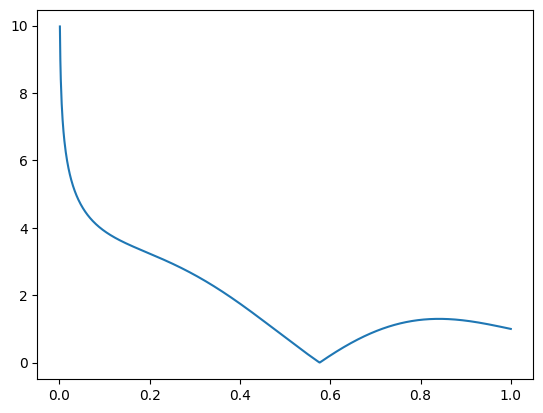

In [17]:
f = lambda x: -1.0 * np.log2(x) - x**2 + np.sin(2.0 * np.pi * x)


test_population = np.arange(1, 1001) * 0.001
X = test_population
Y = fitness_on_population(test_population, f)
plt.plot(X, Y)
plt.show()

In [18]:
best_candidate = ga_solve(f, population_size = 150, iterations = 1000)
print("Best candidate: ", best_candidate)
print("Error (value of |f(best candidate)|): ", np.abs(f(best_candidate)))

wolfram = 0.57648780581413014864739351 # approximate solution produced by Wolfram Alpha, couldn't find exact solution :(
print("Wolfram Alpha approximate solutions: ", wolfram)
print("Difference between best and Wolfram Alpha approx.: ", np.abs(best_candidate - wolfram))


Best candidate:  0.576474732763846
Error (value of |f(best candidate)|):  0.00012062658944245186
Wolfram Alpha approximate solutions:  0.5764878058141302
Difference between best and Wolfram Alpha approx.:  1.3073050284195809e-05
